In [1]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import string
import os
import glob
from PIL import Image
import pprint

from keras import Input, layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

#### Downloaded Flickr Dataset from: https://github.com/goodwillyoga/Flickr8k_dataset

In [2]:
token_path = "./data/Flickr8k_text/Flickr8k.token.txt"
train_images_path = './data/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = './data/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = './data/Flicker8k_Dataset/'

In [3]:
doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


We can see the format in which our image id’s and their captions are stored.
Now, we will create a dictionary named “descriptions” which contains the name of the image as keys and a list of the 5 captions for the corresponding image as values.

In [5]:
descriptions = {}
for line in doc.split('\n'):
    tokens = line.split()
    if(len(line) >  0):
        image_id = tokens[0].split('.')[0]
        image_desc = ' '.join(tokens[1:])
        if image_id not in descriptions:
            descriptions[image_id] = []
        descriptions[image_id].append(image_desc)

# pprint.pprint(descriptions)

Now let's do some basic text cleaning to get rid of punctuation and convert all descriptions text to lowercase.

In [6]:
for key, desc_list in descriptions.items():
    for i, desc in enumerate(desc_list):
        desc = desc.lower()
        desc = desc.translate(str.maketrans('', '', string.punctuation))
        desc_list[i] = desc
    descriptions[key] = desc_list

# pprint.pprint(descriptions)

Let’s visualize an example image and its captions

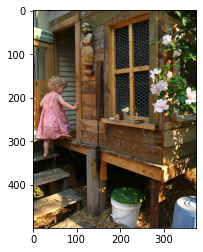

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']


In [7]:
pic = '1000268201_693b08cb0e.jpg'
x = plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

pprint.pprint(descriptions['1000268201_693b08cb0e'])

Now, we will create a vocabulary of all the unique words present across all the 8000*5 image captions.

In [8]:
vocabulary = set()
for key in descriptions.keys():
    for value in descriptions[key]:
        vocabulary.update(value.split())

print('Original Vocabulary Size:', len(vocabulary))

Original Vocabulary Size: 8828


Now let’s save the image id’s and their new cleaned captions in the same format as the token.txt file

In [16]:
lines = []
for key, desc_list in descriptions.items():
    i = 0
    for desc in desc_list:
        lines.append(key+" "+desc)
        i += 1

new_descriptions = "\n".join(lines)

Now, we will load all the 6000 training image id’s in a variable train from the ‘Flickr_8k.trainImages.txt’ file

In [21]:
doc = open(train_images_path, 'r').read()
train_dataset = []
for img_name in doc.split("\n"):
    img = img_name.split(".")[0]
    train_dataset.append(img)

# print(train_dataset)

In [30]:
doc = open(test_images_path, 'r').read()
test_dataset = []
for img_name in doc.split("\n"):
    img = img_name.split(".")[0]
    test_dataset.append(img)

# print(test_dataset)

Let's save all the training and testing images in train_img and test_img lists respectively

In [33]:
all_imgs = glob.glob(images_path+"*.jpg")

train_imgs = []
test_imgs = []

for img_name in all_imgs:
    img = img_name.split(images_path[0:len(images_path)-1]+"\\")[1]
    img = img.split(".")[0]
    if(img in train_dataset):
        train_imgs.append(img_name)
    elif(img in test_dataset):
        test_imgs.append(img_name)

print("Training Images:",len(train_imgs))
print("Testing Images:",len(test_imgs))


Training Images: 6000
Testing Images: 1000
